In [108]:
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent if "notebooks" in str(Path.cwd()) else Path.cwd()
PROJECT_ROOT

PosixPath('/Users/rahulchauhan/Desktop/Satellite-Imagery-Based-Property-Valuation')

In [80]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")

In [81]:
# Use ".." to go up one level from the 'notebooks' folder
train_path = "../data/raw/train.xlsx"
test_path = "../data/raw/test.xlsx"

# Use read_excel for .xlsx files
train_df = pd.read_excel(train_path)
test_df = pd.read_excel(test_path)

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

# Show the first few rows to verify lat/long columns
train_df.head()

Train shape: (16209, 21)
Test shape: (5404, 20)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,9117000170,20150505T000000,268643,4,2.25,1810,9240,2.0,0,0,...,7,1810,0,1961,0,98055,47.4362,-122.187,1660,9240
1,6700390210,20140708T000000,245000,3,2.50,1600,2788,2.0,0,0,...,7,1600,0,1992,0,98031,47.4034,-122.187,1720,3605
2,7212660540,20150115T000000,200000,4,2.50,1720,8638,2.0,0,0,...,8,1720,0,1994,0,98003,47.2704,-122.313,1870,7455
3,8562780200,20150427T000000,352499,2,2.25,1240,705,2.0,0,0,...,7,1150,90,2009,0,98027,47.5321,-122.073,1240,750
4,7760400350,20141205T000000,232000,3,2.00,1280,13356,1.0,0,0,...,7,1280,0,1994,0,98042,47.3715,-122.074,1590,8071


In [82]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16209 entries, 0 to 16208
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             16209 non-null  int64  
 1   date           16209 non-null  object 
 2   price          16209 non-null  int64  
 3   bedrooms       16209 non-null  int64  
 4   bathrooms      16209 non-null  float64
 5   sqft_living    16209 non-null  int64  
 6   sqft_lot       16209 non-null  int64  
 7   floors         16209 non-null  float64
 8   waterfront     16209 non-null  int64  
 9   view           16209 non-null  int64  
 10  condition      16209 non-null  int64  
 11  grade          16209 non-null  int64  
 12  sqft_above     16209 non-null  int64  
 13  sqft_basement  16209 non-null  int64  
 14  yr_built       16209 non-null  int64  
 15  yr_renovated   16209 non-null  int64  
 16  zipcode        16209 non-null  int64  
 17  lat            16209 non-null  float64
 18  long  

In [83]:
missing = train_df.isna().sum()
print(missing)

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64


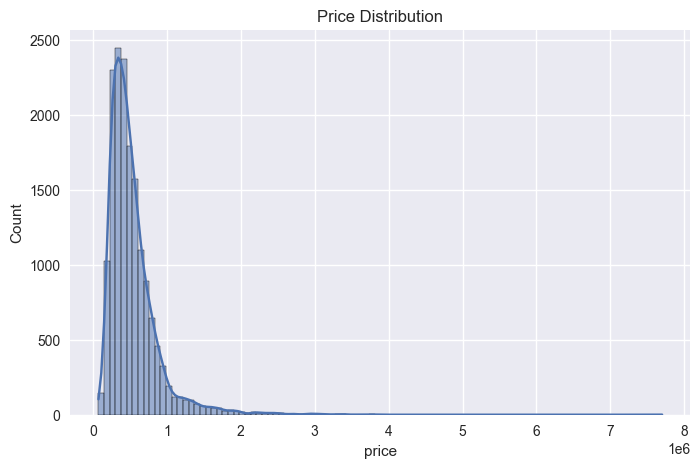

In [84]:
plt.figure(figsize=(8,5))
sns.histplot(data=train_df, x="price", bins=100, kde=True)
plt.title("Price Distribution")
plt.show()


In [85]:
train_df[["lat", "long"]].describe()

,lat,long
count,16209.000000,16209.000000
mean,47.560707,-122.214003
std,0.138340,0.140093
min,47.159300,-122.519000
25%,47.472500,-122.328000
50%,47.572400,-122.230000
75%,47.678200,-122.125000
max,47.777600,-121.315000


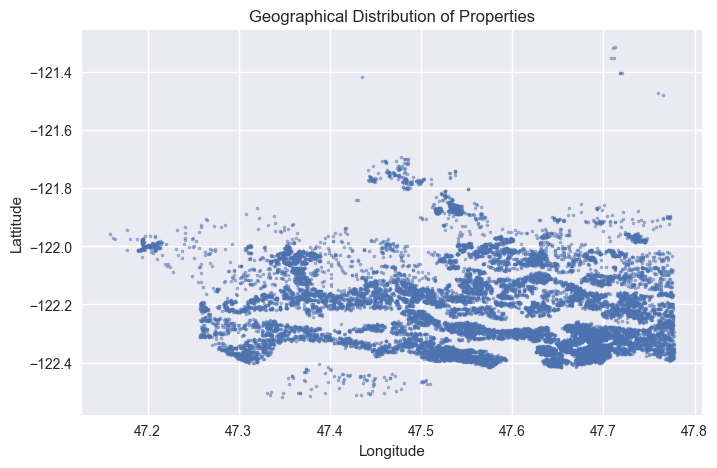

In [86]:
plt.figure(figsize=(8,5))
plt.scatter(
    train_df["lat"],
    train_df["long"],
    alpha=0.5,
    s=5
)
plt.xlabel("Longitude")
plt.ylabel("Lattitude")
plt.title("Geographical Distribution of Properties")
plt.show()


In [87]:
# Create price deciles for stratified sampling
train_df["price_bin"] = pd.qcut(
    train_df["price"],
    q = 10,
    labels=False
)

train_df["price_bin"].value_counts().sort_index()

price_bin
0    1654
1    1588
2    1623
3    1633
4    1665
5    1562
6    1628
7    1653
8    1582
9    1621
Name: count, dtype: int64

Divides prices into 10 equal-frequency buckets

price_bin = 0 → cheapest

price_bin = 9 → most expensive

In [88]:
SAMPLES_PER_BIN = 600
RANDOM_STATE = 42

image_subset_df = (
    train_df
    .groupby("price_bin", group_keys=False)
    .apply(
        lambda x: x.sample(n=SAMPLES_PER_BIN, random_state=RANDOM_STATE),
        include_groups=False  # To silence the pandas warning
    )
)

print(image_subset_df.shape)

(6000, 21)


Each price range equally represented

No bias toward cheap or expensive areas

Stable and reproducible

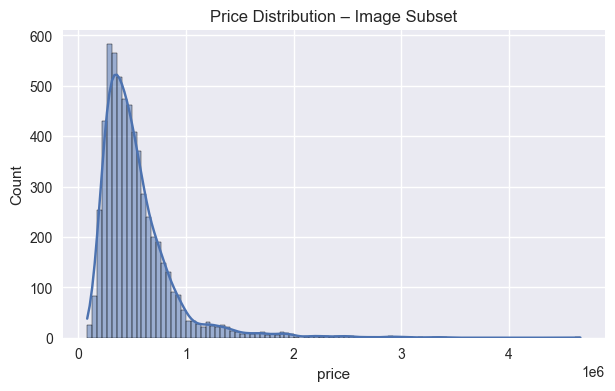

In [89]:
plt.figure(figsize=(7,4))
sns.histplot(image_subset_df["price"] , bins=100 , kde=True)
plt.title("Price Distribution – Image Subset")
plt.show()

 Compare with full dataset

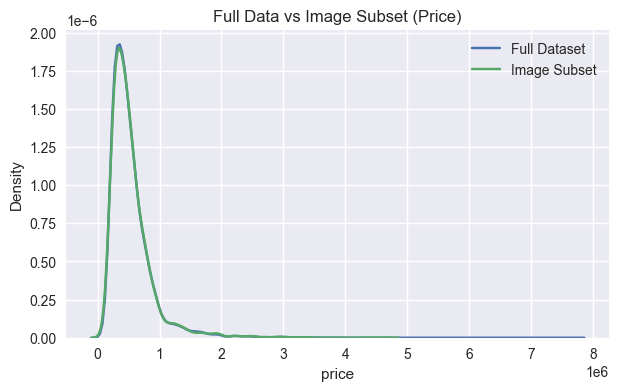

In [90]:
plt.figure(figsize=(7,4))
sns.kdeplot(train_df["price"] , label = "Full Dataset")
sns.kdeplot(image_subset_df["price"] , label = "Image Subset")
plt.legend()
plt.title("Full Data vs Image Subset (Price)")
plt.show()

In [91]:
image_subset_df.columns


Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [92]:
image_subset_path = "../data/processed/train_with_images.csv"

image_subset_df.to_csv(
    image_subset_path,
    index=False
)

print(f"Saved image subset to {image_subset_path}")

Saved image subset to ../data/processed/train_with_images.csv


#### Price vs sqft_living

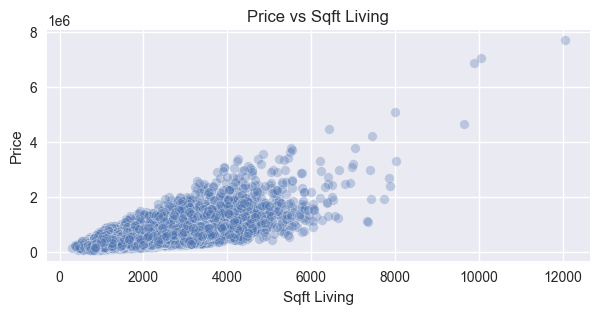

In [93]:
plt.figure(figsize=(7,3))
sns.scatterplot(
    x=train_df["sqft_living"],
    y=train_df["price"],
    alpha=0.3
)
plt.title("Price vs Sqft Living")
plt.xlabel("Sqft Living")
plt.ylabel("Price")
plt.show()


#### Price vs waterfront

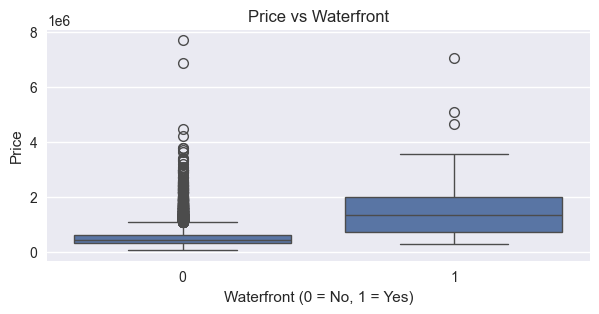

In [94]:
plt.figure(figsize=(7,3))
sns.boxplot(
    x=train_df["waterfront"],
    y=train_df["price"]
)
plt.title("Price vs Waterfront")
plt.xlabel("Waterfront (0 = No, 1 = Yes)")
plt.ylabel("Price")
plt.show()


#### Price vs view

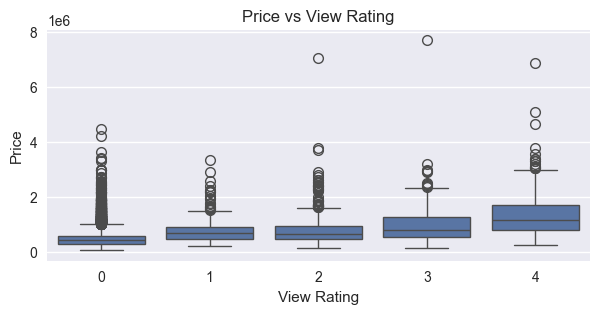

In [95]:
plt.figure(figsize=(7,3))
sns.boxplot(
    x=train_df["view"],
    y=train_df["price"]
)
plt.title("Price vs View Rating")
plt.xlabel("View Rating")
plt.ylabel("Price")
plt.show()


#### Plot Properties on Map (Lat/Long)

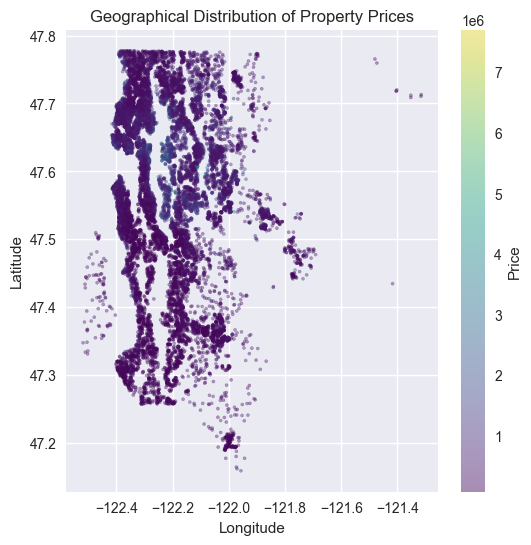

In [96]:
plt.figure(figsize=(6,6))
plt.scatter(
    train_df["long"],
    train_df["lat"],
    c=train_df["price"],
    cmap="viridis",
    alpha=0.4,
    s=5
)
plt.colorbar(label="Price")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geographical Distribution of Property Prices")
plt.show()


In [97]:
import pandas as pd

raw_train = pd.read_excel("../data/raw/train.xlsx")
raw_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,9117000170,20150505T000000,268643,4,2.25,1810,9240,2.0,0,0,...,7,1810,0,1961,0,98055,47.4362,-122.187,1660,9240
1,6700390210,20140708T000000,245000,3,2.50,1600,2788,2.0,0,0,...,7,1600,0,1992,0,98031,47.4034,-122.187,1720,3605
2,7212660540,20150115T000000,200000,4,2.50,1720,8638,2.0,0,0,...,8,1720,0,1994,0,98003,47.2704,-122.313,1870,7455
3,8562780200,20150427T000000,352499,2,2.25,1240,705,2.0,0,0,...,7,1150,90,2009,0,98027,47.5321,-122.073,1240,750
4,7760400350,20141205T000000,232000,3,2.00,1280,13356,1.0,0,0,...,7,1280,0,1994,0,98042,47.3715,-122.074,1590,8071


In [98]:
tabular_df = raw_train.drop(columns=["id", "date"])
tabular_df.head()


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,268643,4,2.25,1810,9240,2.0,0,0,3,7,1810,0,1961,0,98055,47.4362,-122.187,1660,9240
1,245000,3,2.50,1600,2788,2.0,0,0,4,7,1600,0,1992,0,98031,47.4034,-122.187,1720,3605
2,200000,4,2.50,1720,8638,2.0,0,0,3,8,1720,0,1994,0,98003,47.2704,-122.313,1870,7455
3,352499,2,2.25,1240,705,2.0,0,0,3,7,1150,90,2009,0,98027,47.5321,-122.073,1240,750
4,232000,3,2.00,1280,13356,1.0,0,0,3,7,1280,0,1994,0,98042,47.3715,-122.074,1590,8071


In [99]:
tabular_df.to_csv(
    "../data/processed/train_tabular.csv",
    index=False
)

print("train_tabular.csv saved successfully")


train_tabular.csv saved successfully


In [114]:
import os
os.getcwd()


'/Users/rahulchauhan/Desktop/Satellite-Imagery-Based-Property-Valuation/notebooks'

In [115]:
import os

os.listdir("../data/images")[:5]


['1931300175.0.png',
 '2652500070.0.png',
 '7504100110.0.png',
 '2062600020.0.png',
 '3727800065.0.png']

In [118]:
import os
import pandas as pd
from pathlib import Path

# Reload clean
image_df = pd.read_csv("../data/processed/train_with_images.csv")

# IMPORTANT: ensure id is float so '.0' exists
image_df["id"] = image_df["id"].astype(float)

IMAGE_DIR = Path("../data/images")

# Build paths that MATCH the actual filenames on disk
image_df["image_path"] = image_df["id"].apply(
    lambda x: IMAGE_DIR / f"{x}.png"
)

image_df[["id", "image_path"]].head()


,id,image_path
0,9.543000e+09,../data/images/9543000205.0.png
1,3.353400e+09,../data/images/3353400120.0.png
2,2.976801e+09,../data/images/2976800749.0.png
3,7.335400e+09,../data/images/7335400020.0.png
4,7.883601e+09,../data/images/7883600700.0.png


In [119]:
image_df["image_exists"] = image_df["image_path"].apply(lambda x: x.exists())
image_df["image_exists"].value_counts()


image_exists
True     5998
False       2
Name: count, dtype: int64

In [120]:
image_df = image_df[image_df["image_exists"]].reset_index(drop=True)
image_df.shape


(5998, 23)

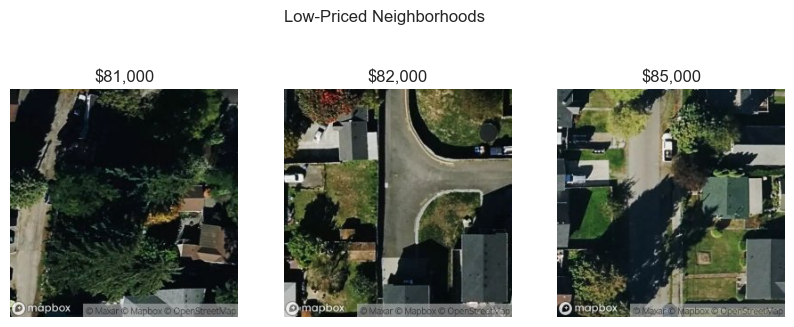

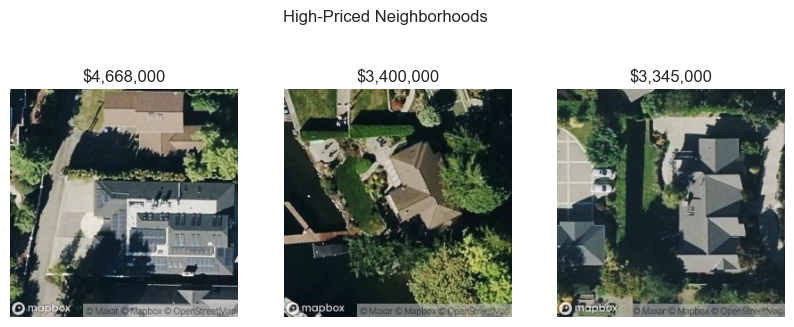

In [122]:
from PIL import Image
import matplotlib.pyplot as plt

cheap = image_df.nsmallest(3, "price")
expensive = image_df.nlargest(3, "price")

def show_images(df, title):
    plt.figure(figsize=(10,4))
    for i, (_, row) in enumerate(df.iterrows()):
        img = Image.open(row["image_path"])
        plt.subplot(1, len(df), i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"${row['price']:,}")
    plt.suptitle(title)
    plt.show()

show_images(cheap, "Low-Priced Neighborhoods")
show_images(expensive, "High-Priced Neighborhoods")
